In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/myanimelist/UserAnimeList.csv
/kaggle/input/myanimelist/animelists_cleaned.csv
/kaggle/input/myanimelist/users_filtered.csv
/kaggle/input/myanimelist/anime_filtered.csv
/kaggle/input/myanimelist/AnimeList.csv
/kaggle/input/myanimelist/users_cleaned.csv
/kaggle/input/myanimelist/UserList.csv
/kaggle/input/myanimelist/animelists_filtered.csv
/kaggle/input/myanimelist/anime_cleaned.csv


In [2]:
df = pd.read_csv('/kaggle/input/myanimelist/animelists_cleaned.csv')

In [3]:
column_list = df.columns
useful_cols = ['username', 'anime_id', 'my_score', 'my_last_updated']
useless_cols = [col for col in df.columns if col not in useful_cols]

df.drop(columns=useless_cols, inplace=True)
username_list = df.sample(frac=0.0004, replace=True, random_state=0)['username'].unique()

In [4]:
username_set = set(username_list)
df = df[df['username'].isin(username_set)]

In [5]:
df['time_stamp'] = (pd.to_datetime(df.my_last_updated) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [6]:
df.drop(columns=['my_last_updated'], inplace=True)
df = df[df['my_score']>5]
df['anime_id'] = df['anime_id'].astype('str')
df_agg = df.sort_values(['time_stamp'],ascending=True).groupby(['username'])['anime_id'].apply(' '.join).reset_index()

In [7]:
df_agg.to_csv('animelists_sampled0.0004_seq.csv')

In [8]:
df_agg

,username,anime_id
0,--kitade--,50 49 303 880 304 53 102 4744 6987 8577 3549 5...
1,-Alberto-,356 6922 11741 10087 14829 20853 17265 527 528...
2,-Amaya--,31859 31043 17265 23321 30831 19815 11757 2188...
3,-Angel-,129 3193 2508 1281 238 289 846 390 170 127 290...
4,-AsakuraShin-,4186 1575 2904 2167 4181 2026 4192 4975 62 521...
...,...,...
10935,zonnikku,1074 22 552 572 874 986 895 905 906 31368 985 ...
10936,zra319,10495 27775 29785 28825 18619 14131 30544 2327...
10937,zwars,306 303 1292 49 50 880 304 101 713 656 1896 47...
10938,zxnno,2167 4181 11757 1691 11111 8841 10790 79 5682 ...


In [9]:


import multiprocessing

from gensim.models import Word2Vec



In [10]:
def split_seq(string):
    return string.split(' ')

In [11]:
df_agg['anime_id'] = df_agg['anime_id'].apply(split_seq)

In [12]:
w2v_num_dims = 20
w2v_downsample_threshold = 1e-5
w2v_lr = 0.03
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=5,
                     window=5,
                     vector_size=w2v_num_dims,
                     sample=w2v_downsample_threshold, 
                     alpha=w2v_lr, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)



In [13]:
w2v_model.build_vocab(df_agg['anime_id'], progress_per=10000)

In [14]:
w2v_model.corpus_count

10940

In [15]:
%%time
w2v_model.train(df_agg['anime_id'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 3min 5s, sys: 938 ms, total: 3min 6s
Wall time: 1min 5s


(23676001, 100406040)

In [16]:
anime_df = pd.read_csv('/kaggle/input/myanimelist/anime_filtered.csv', index_col='anime_id')

In [17]:
synonyms = w2v_model.wv.most_similar(positive=["5941"])
synonyms_id = [int(syn) for (syn, cos) in synonyms]

In [18]:
!pip install bs4

     |████████████████████████████████| 115 kB 410 kB/s 
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=22f6f616a1d0205afbf1e290c0ebd75fb8ef92950e80324eda9ceb210a0a5fc6
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [19]:
from bs4 import BeautifulSoup
import requests

recommended_img = []
for anime_id in synonyms_id:
    html_page = requests.get('https://myanimelist.net/anime/'+str(anime_id))
    soup = BeautifulSoup(html_page.content, 'html.parser')
    content = soup.find('div', id="content")
    recommended_img.append(content.table.tr.td.div.div.a.img.get('data-src'))


In [20]:
import io
from urllib.request import urlopen, Request
from urllib.parse import urlparse
from PIL import Image
from PIL.Image import Image as PilImage

def url_to_pil(url:str, label) -> PilImage:
    headers = { 'User-Agent': 'Mozilla/6.0'}
    data = urlopen(Request(url, headers=headers)).read()
    bts = io.BytesIO(data)
    im = Image.open(bts)
#     im.filename = urlparse(url).path
    im.filename = label
    return im

In [21]:
recommended_title = anime_df.loc[synonyms_id].title.tolist()
images = [url_to_pil(u, t) for u, t in zip(recommended_img, recommended_title)]

In [22]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap

def display_images(
    images: [PilImage], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) // columns + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

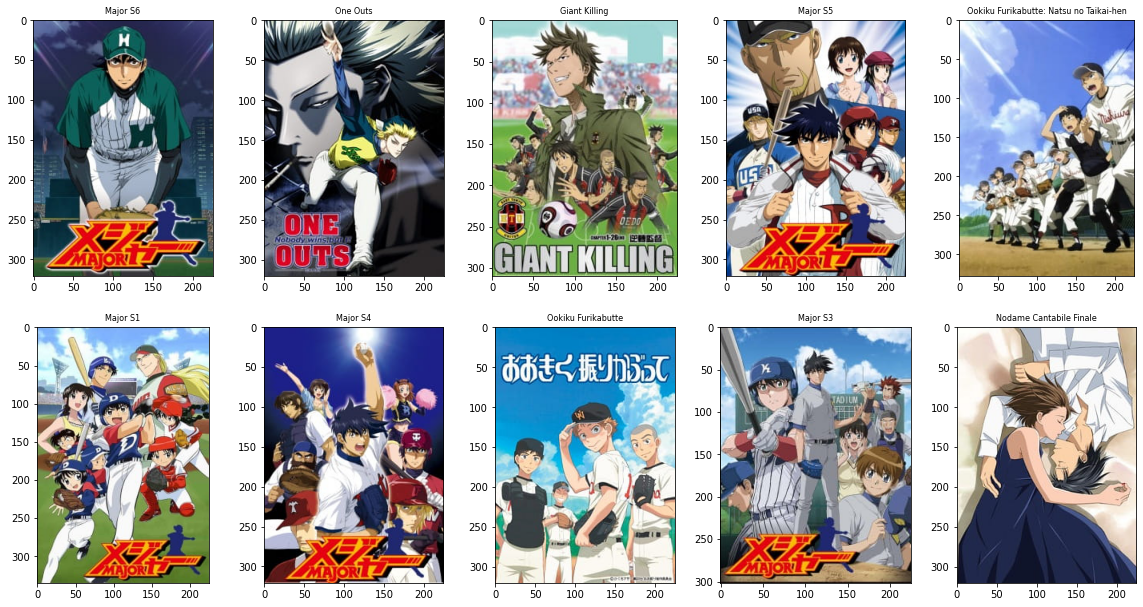

In [23]:
display_images(images)

In [24]:
def reco(query_id:str, topk:int):
    # need anime_df
    synonyms = w2v_model.wv.most_similar(positive=[query_id], topn=topk)
    synonyms_id = []
    for synonym, cosineSimilarity in synonyms:
#         print(synonym, cosineSimilarity)
        synonyms_id.append(int(synonym))
    
    query_title = anime_df.loc[int(query_id)].title
    
    print(f'ID: {query_id} Title: {query_title}')
    print(f"Here's top-{topk} recommendation below:" )

    recommended_title = anime_df.loc[synonyms_id].title.tolist()
    recommended_img = []

    for anime_id in synonyms_id:
        html_page = requests.get('https://myanimelist.net/anime/'+str(anime_id))
        soup = BeautifulSoup(html_page.content, 'html.parser')
        content = soup.find('div', id="content")
        recommended_img.append(content.table.tr.td.div.div.a.img.get('data-src'))

    images = [url_to_pil(u, t) for u, t in zip(recommended_img, recommended_title)]


    display_images(images)

ID: 934 Title: Higurashi no Naku Koro ni
Here's top-10 recommendation below:


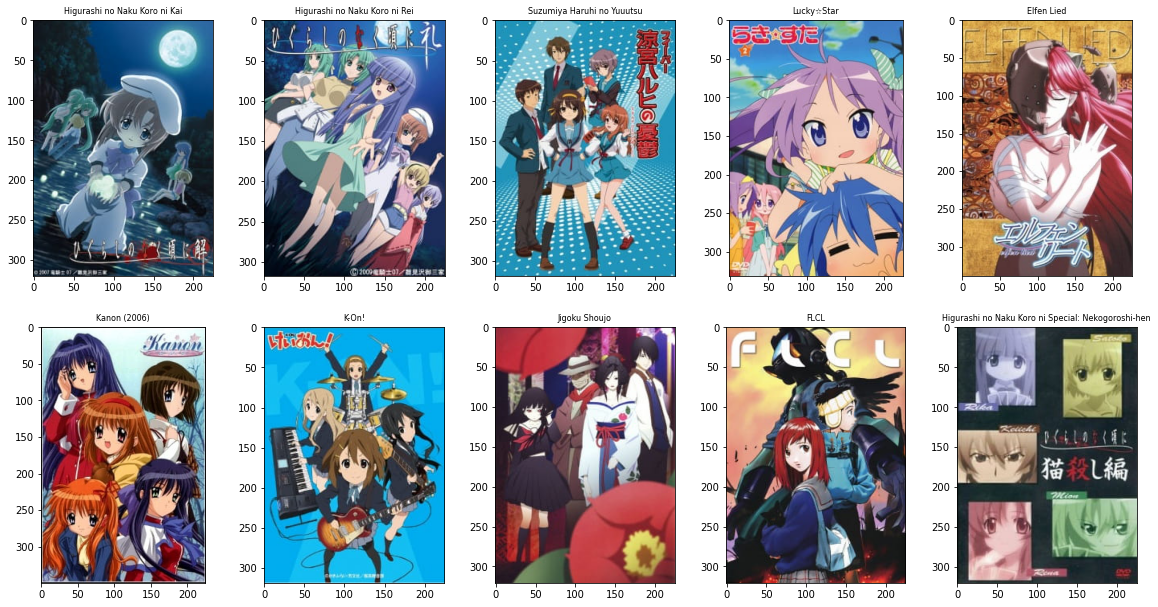

In [25]:
reco('934', 10)